In [169]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
plt.rcParams['image.cmap'] = 'gist_earth'
np.random.seed(98765)

In [183]:
# Data Augmentation 
# Random Crop
# Random Flip
import os
import skimage
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchvision.transforms import Compose, TenCrop, Lambda
import torchvision.transforms as vis_tf
from glob import glob
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/Users/trimchala/BreastPathQ/breastpathq/tf_unet/')
import tf_unet
from tf_unet.image_util import BaseDataProvider
 
%load_ext autoreload

%autoreload 2
plt.ion()   # interactive mode

dataset_path = '/Users/trimchala/BreastPathQ/breastpathq/datasets/MoNuSegTraining'
image_path = os.path.join(dataset_path, 'TissueImages')
mask_path = os.path.join(dataset_path, 'LabeledNucImages')


class MonuSegDataProvider(BaseDataProvider):
    def __init__(
        self, 
        image_path, 
        mask_path, 
        transforms=None, shuffle_data=True, 
        a_min=None, a_max=None, 
    ):
        super(MonuSegDataProvider, self).__init__(a_min, a_max)
        # stuff
        self.image_path = image_path
        self.mask_path = mask_path
        self.file_idx = -1
        self.transforms = transforms
        self.image_list = glob(os.path.join(self.image_path, "*.tif"))
        self.mask_list = glob(os.path.join(self.mask_path, "*.png"))
        self.shuffle_data = shuffle_data
        
#         if self.shuffle_data:
#             np.random.shuffle(self.data_files)
        
        assert len(self.image_list) > 0, "No training files"
        print("Number of files used: %s" % len(self.image_list))
        
        test_img = cv2.imread(self.image_list[0])
        self.channels = 1 if len(test_img.shape) == 2 else test_img.shape[-1]
        
    def _load_file(self, path, dtype=np.float32):
        return np.array(PIL.Image.open(path), dtype)

    
    def _cylce_file(self):
        self.file_idx += 1
        if self.file_idx >= len(self.image_list):
            self.file_idx = 0 
#             if self.shuffle_data:
#                 np.random.shuffle(self.image_list)


    def _next_data(self):
        self._cylce_file()
        image_file = self.image_list[self.file_idx]
        mask_file = image_file.replace(self.image_path, self.mask_path).replace(".tif", ".png")
        
        img = cv2.imread(image_file)        
        mask_gray = np.array(
            PIL.Image.fromarray(cv2.imread(mask_file)).convert('L')
        )
#         mask0 = (mask_gray <= mask_gray.min()).astype(int)
#         mask1 = (mask_gray > mask_gray.min()).astype(int)
#         mask = np.dstack([mask0, mask1])
        mask = (mask_gray > mask_gray.min()).astype(int)
                        
#         if self.transforms is not None:
#             img = self.transforms(img)
#             mask = self.transforms(mask)
#         else: 
#             pil2tensor = vis_tf.Compose([vis_tf.ToTensor()])
#             img = pil2tensor(img)
#             mask = pil2tensor(mask)
    
        return img, mask


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
import os
import sys
sys.path.append('/Users/trimchala/BreastPathQ/breastpathq/tf_unet/')
sys.path.append('/Users/trimchala/BreastPathQ/breastpathq/tf_unet/tf_unet/')
sys.path.append('/Users/trimchala/BreastPathQ/breastpathq/tf_unet/scripts/')
os.chdir('/Users/trimchala/BreastPathQ/breastpathq/tf_unet/')
from tf_unet import image_gen
from tf_unet import unet
from tf_unet import util

monuseg_generator = MonuSegDataProvider(image_path, mask_path)

unet32 = unet.Unet(
    channels=monuseg_generator.channels, 
    n_class=monuseg_generator.n_class, 
    layers=3, 
    features_root=16
)

trainer = unet.Trainer(unet32, optimizer="momentum", opt_kwargs=dict(momentum=0.2))

2018-11-24 12:03:27,715 Layers 3, features 16, filter size 3x3, pool size: 2x2


Number of files used: 30


In [186]:
path = trainer.train(
    monuseg_generator, 
    "./tf_unet_monuseg_trained", 
    training_iters=32, epochs=5,
    display_step=20, 
    prediction_path='prediction_inverse'
)

2018-11-24 12:04:10,924 Removing '/Users/trimchala/BreastPathQ/breastpathq/tf_unet/prediction'
2018-11-24 12:04:10,970 Removing '/Users/trimchala/BreastPathQ/breastpathq/tf_unet/tf_unet_monuseg_trained'
2018-11-24 12:04:10,973 Allocating '/Users/trimchala/BreastPathQ/breastpathq/tf_unet/prediction'
2018-11-24 12:04:10,974 Allocating '/Users/trimchala/BreastPathQ/breastpathq/tf_unet/tf_unet_monuseg_trained'
2018-11-24 12:04:33,939 Verification error= 100.0%, loss= -0.5699
2018-11-24 12:04:35,797 Start optimization
2018-11-24 12:04:54,065 Iter 0, Minibatch Loss= -0.7616, Training Accuracy= 1.0000, Minibatch error= 0.0%
2018-11-24 12:07:57,251 Iter 20, Minibatch Loss= -4.1874, Training Accuracy= 1.0000, Minibatch error= 0.0%
2018-11-24 12:10:20,942 Epoch 0, Average loss: -2.1809, learning rate: 0.2000
2018-11-24 12:10:49,927 Verification error= 0.0%, loss= -2.4048
2018-11-24 12:12:23,053 Iter 40, Minibatch Loss= -4.8880, Training Accuracy= 1.0000, Minibatch error= 0.0%
2018-11-24 12:15:43

In [187]:
x_test, y_test = monuseg_generator(1)

prediction = unet32.predict("./tf_unet_monuseg_trained/model.ckpt", x_test)

INFO:tensorflow:Restoring parameters from ./tf_unet_monuseg_trained/model.ckpt


2018-11-24 12:36:06,022 Restoring parameters from ./tf_unet_monuseg_trained/model.ckpt
2018-11-24 12:36:06,165 Model restored from file: ./tf_unet_monuseg_trained/model.ckpt


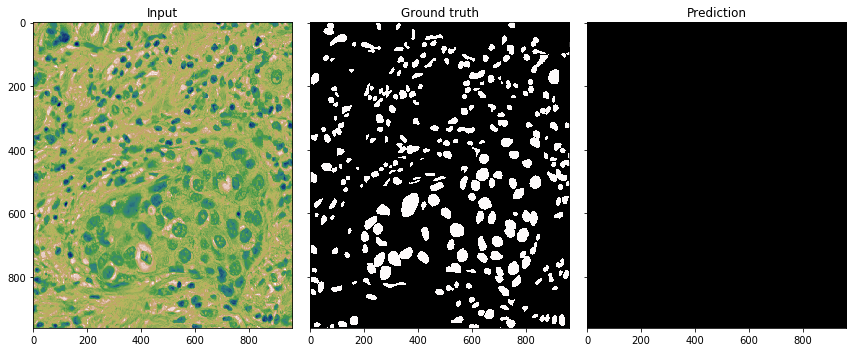

In [188]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,0], aspect="auto")
mask = prediction[0,...,1] > 0.1
ax[2].imshow(mask, aspect="auto")
ax[0].set_title("Input")
ax[1].set_title("Ground truth")
ax[2].set_title("Prediction")
fig.tight_layout()

## Continue training with smaller learning rate

In [189]:
trainer_slower = unet.Trainer(
    unet32, optimizer="momentum", 
    opt_kwargs=dict(momentum=0.2, learning_rate=0.05)
)
path = trainer_slower.train(
    monuseg_generator, 
    "./tf_unet_monuseg_trained_continue", 
    training_iters=32, epochs=25,
    display_step=16
)

2018-11-24 12:52:09,789 Removing '/Users/trimchala/BreastPathQ/breastpathq/tf_unet/prediction'
2018-11-24 12:52:09,798 Removing '/Users/trimchala/BreastPathQ/breastpathq/tf_unet/tf_unet_monuseg_trained_continue'
2018-11-24 12:52:09,801 Allocating '/Users/trimchala/BreastPathQ/breastpathq/tf_unet/prediction'
2018-11-24 12:52:09,805 Allocating '/Users/trimchala/BreastPathQ/breastpathq/tf_unet/tf_unet_monuseg_trained_continue'
2018-11-24 12:52:41,313 Verification error= 19.2%, loss= -0.7157
2018-11-24 12:52:44,136 Start optimization
2018-11-24 12:53:02,970 Iter 0, Minibatch Loss= -0.9002, Training Accuracy= 1.0000, Minibatch error= 0.0%
2018-11-24 12:58:20,557 Iter 16, Minibatch Loss= -1.8661, Training Accuracy= 1.0000, Minibatch error= 0.0%
2018-11-24 13:03:03,231 Epoch 0, Average loss: -1.8625, learning rate: 0.0500
2018-11-24 13:03:27,830 Verification error= 0.0%, loss= -2.1475
2018-11-24 13:03:48,441 Iter 32, Minibatch Loss= -2.1667, Training Accuracy= 1.0000, Minibatch error= 0.0%
20

2018-11-24 15:20:08,818 Epoch 21, Average loss: -4.3038, learning rate: 0.0170
2018-11-24 15:20:22,923 Verification error= 10.1%, loss= -4.0665
2018-11-24 15:20:37,116 Iter 704, Minibatch Loss= -3.2403, Training Accuracy= 0.7542, Minibatch error= 24.6%
2018-11-24 15:23:12,014 Iter 720, Minibatch Loss= -4.4231, Training Accuracy= 0.8763, Minibatch error= 12.4%
2018-11-24 15:25:36,492 Epoch 22, Average loss: -4.1972, learning rate: 0.0162
2018-11-24 15:25:51,090 Verification error= 13.3%, loss= -3.5712
2018-11-24 15:26:04,349 Iter 736, Minibatch Loss= -2.1369, Training Accuracy= 0.4237, Minibatch error= 57.6%
2018-11-24 15:28:22,915 Iter 752, Minibatch Loss= -3.8223, Training Accuracy= 0.9092, Minibatch error= 9.1%
2018-11-24 15:30:39,933 Epoch 23, Average loss: -4.1360, learning rate: 0.0154
2018-11-24 15:30:56,864 Verification error= 10.1%, loss= -4.1279
2018-11-24 15:31:11,319 Iter 768, Minibatch Loss= -4.5129, Training Accuracy= 0.8226, Minibatch error= 17.7%
2018-11-24 15:33:41,783 

In [ ]:
# Continue with restore True
# !cp -r tf_unet_monuseg_trained_continue/ tf_unet_monuseg_trained_restore/

In [192]:
# Continue with restore True
trainer_restore = unet.Trainer(
    unet32, optimizer="momentum", 
    opt_kwargs=dict(momentum=0.25, learning_rate=0.01)
)

path_store = trainer_restore.train(
    monuseg_generator, 
    "./tf_unet_monuseg_trained_restore", 
    training_iters=32, epochs=25,
    display_step=16, 
    prediction_path='prediction_restore',
    restore=True # Need this so it continue from the checkpoint
)

2018-11-24 15:54:48,597 Allocating '/Users/trimchala/BreastPathQ/breastpathq/tf_unet/prediction_restore'


INFO:tensorflow:Restoring parameters from ./tf_unet_monuseg_trained_restore/model.ckpt


2018-11-24 15:54:49,049 Restoring parameters from ./tf_unet_monuseg_trained_restore/model.ckpt


NotFoundError: Key down_conv_0/b1/Momentum_2 not found in checkpoint
	 [[Node: save_31/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_31/Const_0_0, save_31/RestoreV2/tensor_names, save_31/RestoreV2/shape_and_slices)]]

Caused by op 'save_31/RestoreV2', defined at:
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-192-902aa14e79f8>", line 12, in <module>
    restore=True # Need this so it continue from the checkpoint
  File "/Users/trimchala/BreastPathQ/breastpathq/tf_unet/tf_unet/unet.py", line 420, in train
    self.net.restore(sess, ckpt.model_checkpoint_path)
  File "/Users/trimchala/BreastPathQ/breastpathq/tf_unet/tf_unet/unet.py", line 301, in restore
    saver = tf.train.Saver()
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1338, in __init__
    self.build()
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1347, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1384, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 835, in _build_internal
    restore_sequentially, reshape)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 472, in _AddRestoreOps
    restore_sequentially)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 886, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1463, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/Users/trimchala/miniconda/envs/w2synth-pytorch/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key down_conv_0/b1/Momentum_2 not found in checkpoint
	 [[Node: save_31/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_31/Const_0_0, save_31/RestoreV2/tensor_names, save_31/RestoreV2/shape_and_slices)]]
